# 2nd Derivative weighted loss function

Notebook exploring the development of a loss function that is weighted based on the second derivative.  

The second derivative has a large negative value at the stick -> slip transition and large positive value at the slip -> stick transition. A loss function weighted by the second derivative (with possible seperate weightings dependent on whether it is positive or negative) should help any ML model to prioritise learning to accurately forecast start and end of failures.

## Setup

In [2]:
# Import libraries
import sys
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch
import json
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Import local modules
from utils.dataset import SlowEarthquakeDataset
import utils.general_functions as gfn
from utils.data_preprocessing import moving_average_causal_filter, create_dataset, normalise_dataset

In [3]:
# Set random seed
SEED = 17 # random seed for the dataset and model
gfn.set_seed(SEED)

# Set torch device
device = gfn.set_torch_device()

No GPU available.


## Load data

In [4]:
# Define experiment list
EXPERIMENTS = [
    "cascadia",
    "p4679",
    "p4581",
    "b726",
    "b698",
    "i417",
    "sim_b726",
    "sim_b698",
    "sim_i417",
]

# Initialize the dataset loader with all experiments and load the data
dataset_loader = SlowEarthquakeDataset(EXPERIMENTS)
dataset_loader.load()

# Store all datasets in a single dataframe
df = {
    exp: dataset_loader.convert_to_df(exp)
    .rename(columns={"seg_avg" if exp == "cascadia" else "obs_shear_stress": "X"})[["X"]]
    for exp in EXPERIMENTS
}

## Standardised data pre-processing

### Downsampling and smoothing

In [5]:
# Get standardised downsampling and smoothing factors
with open("../conf.json", "r") as f:
    config = json.load(f)

config


{'cascadia': {'smoothing_window': 10, 'downsampling_factor': 1},
 'p4679': {'smoothing_window': 13, 'downsampling_factor': 13},
 'p4581': {'smoothing_window': 26, 'downsampling_factor': 26},
 'b726': {'smoothing_window': 1, 'downsampling_factor': 1},
 'b698': {'smoothing_window': 2, 'downsampling_factor': 2},
 'i417': {'smoothing_window': 2, 'downsampling_factor': 2},
 'sim_b726': {'smoothing_window': 1, 'downsampling_factor': 1},
 'sim_b698': {'smoothing_window': 2, 'downsampling_factor': 2},
 'sim_i417': {'smoothing_window': 2, 'downsampling_factor': 2}}

In [6]:
# Smooth and downsample
df_filtered = {
    exp: moving_average_causal_filter(df[exp], **config[exp])
    for exp in EXPERIMENTS
}

### Scaling

In [7]:
# Data scaling
scaler = MinMaxScaler()

df_filtered_sc = {
    exp: scaler.fit_transform(df_filtered[exp])
    for exp in EXPERIMENTS
}

### Visualise datasets

/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

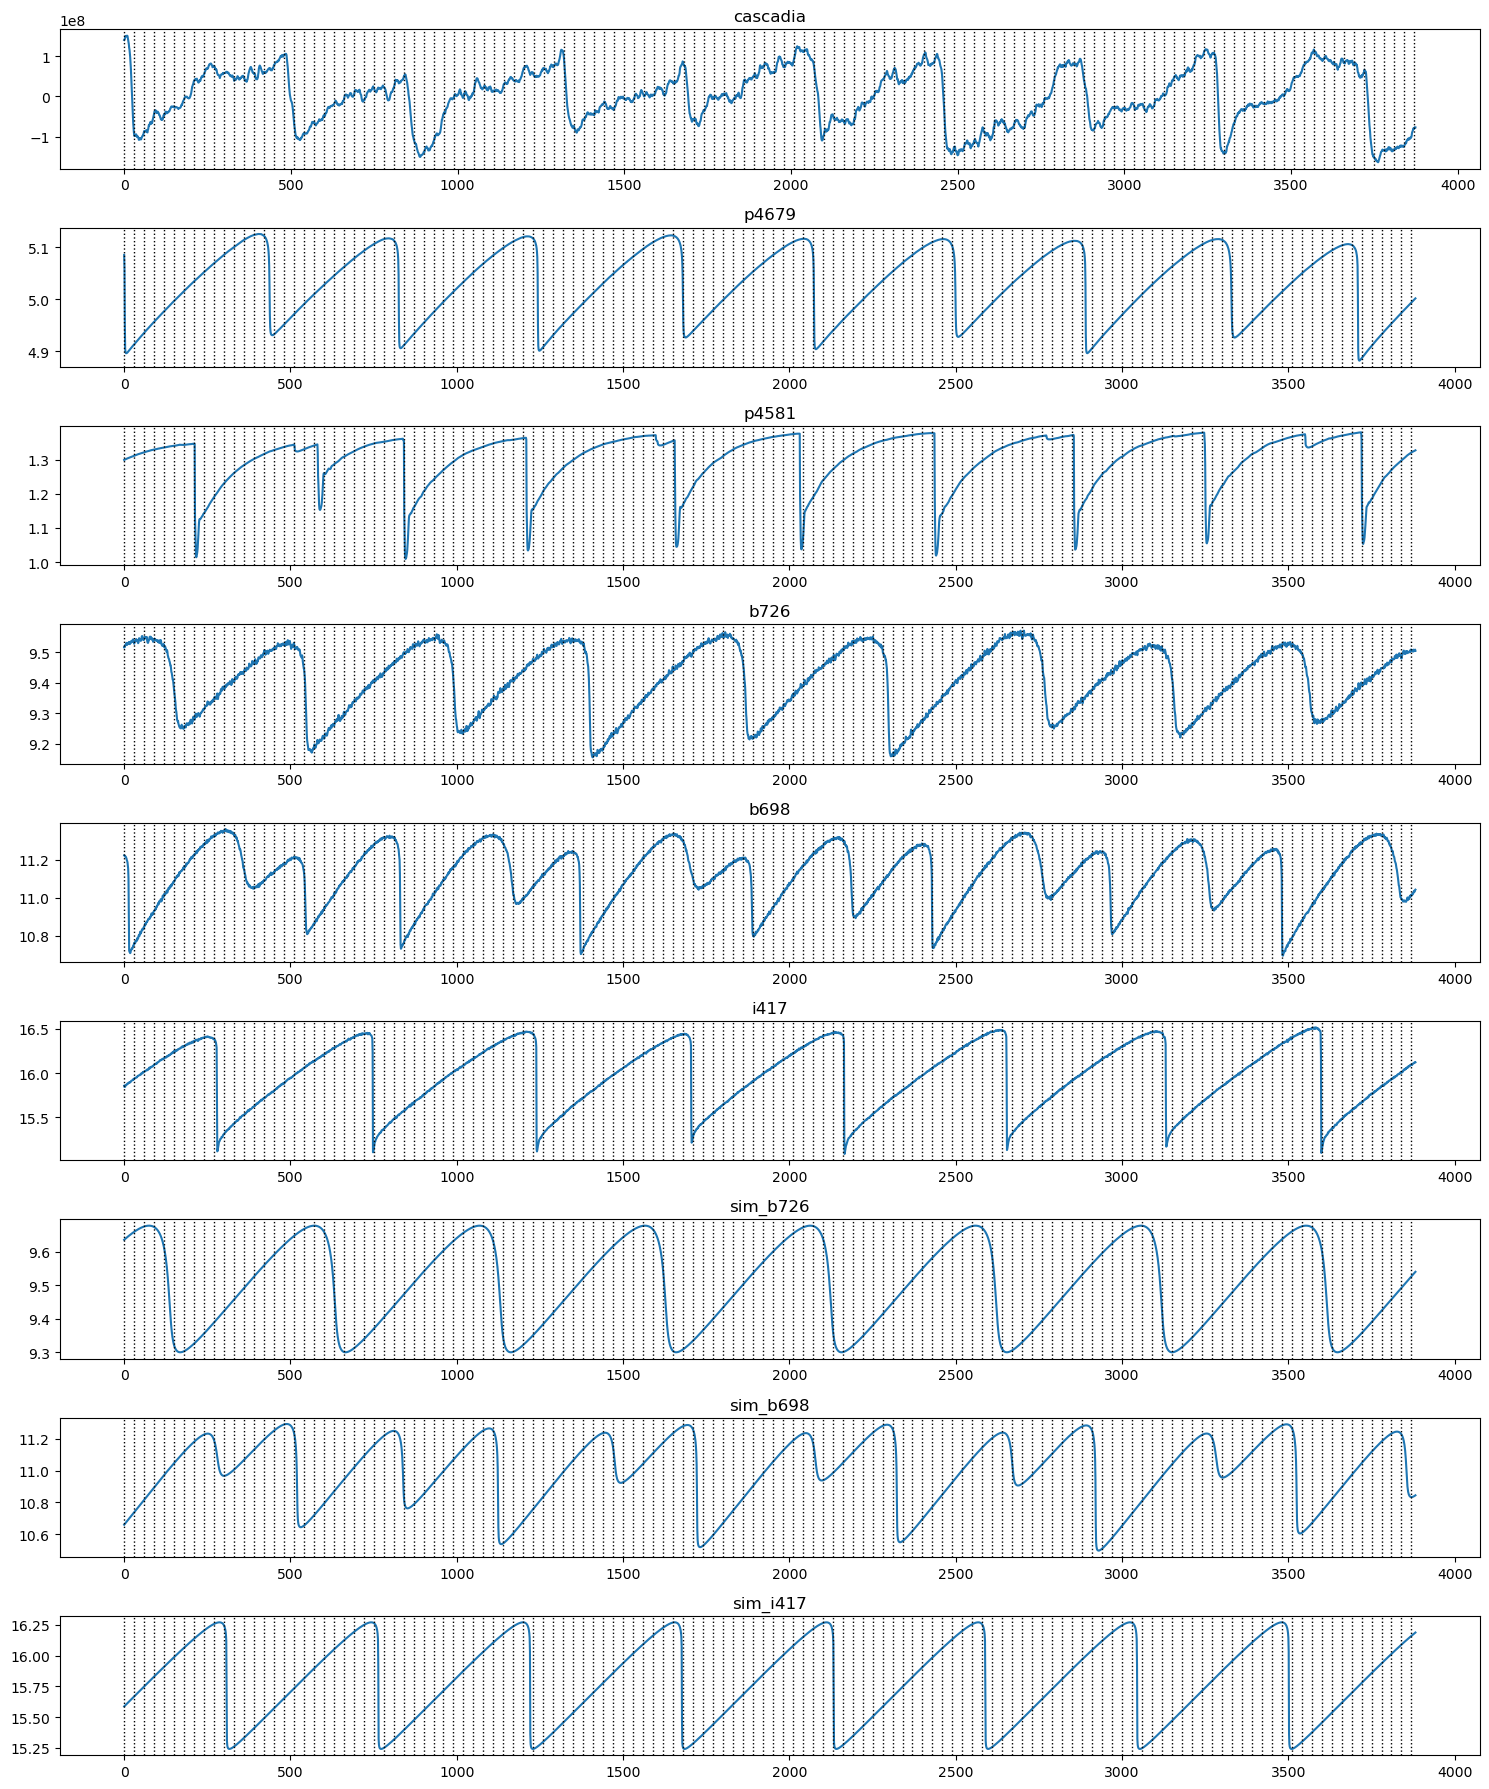

In [7]:
# Plot pre-processed data (smoothed and downsampled)

## Truncate length of all dataframes to match the length of 'cascadia' dataframe
cascadia_length = len(df["cascadia"])

df_truncated = {exp: df_exp.head(cascadia_length) for exp, df_exp in df_filtered.items()}

## Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp].reset_index()  # Reset index to ensure 'id' column exists
    sns.lineplot(data=data, x=data.index, y="X")  # Use the DataFrame index for x
    for x in np.arange(0, len(data), 30):
        plt.axvline(x=x, color='black', linestyle=':', linewidth=1)
    plt.title(exp)
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()
plt.show()


/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

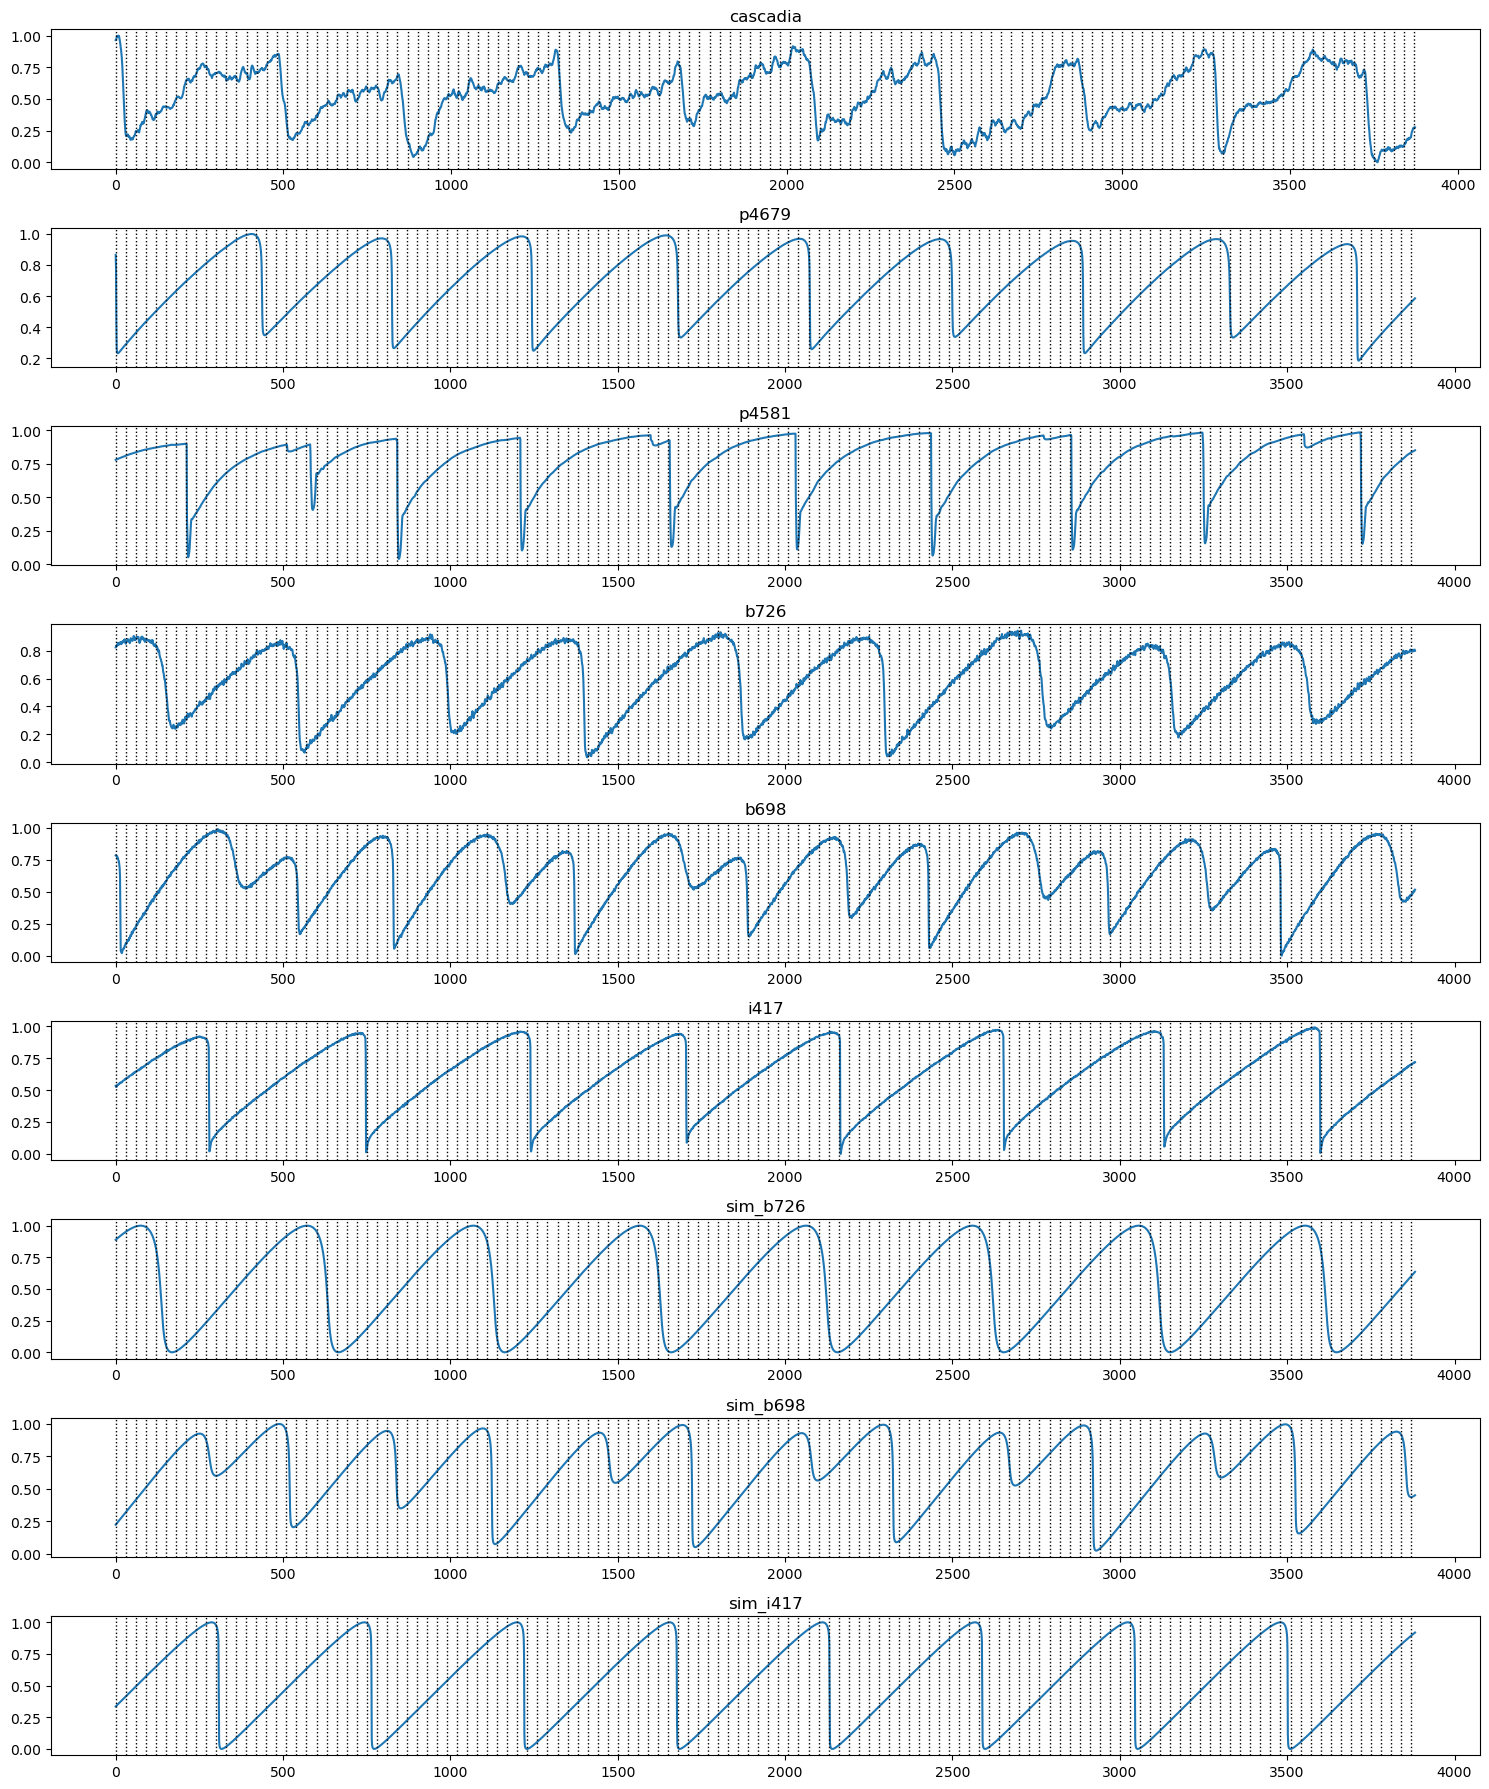

In [25]:
# Truncate length of all arrays to match the length of 'cascadia' array
cascadia_length = len(df["cascadia"])
df_truncated = {exp: df_exp[:cascadia_length] for exp, df_exp in df_filtered_sc.items()}

# Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp]  # NumPy array
    y_values = data[:, 0]  # Assuming you want to plot the first column
    x_values = np.arange(len(y_values))  # Assuming x-axis is just index
    sns.lineplot(x=x_values, y=y_values)  # Plotting NumPy array directly
    for x in np.arange(0, len(y_values), 30):
        plt.axvline(x=x, color='black', linestyle=':', linewidth=1)
    plt.title(exp)
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()
plt.show()


## Full dataset derivatives

### Additional Smoothing

Using df_filtered_sc as a starting point since these are the datapoints that will be inputed into the loss function

PROBLEM: 
- Extra_smoothing_window has to be comparable to the forecast length before signal looks sufficiently smoothed - this would make calculating derivatives based on windwowed y_true and y_pred comparisons problematic because of large edge effects
- This is mostly a problem for Cascadia, a smaller extra_smoothing_window should be fine for the other datasets


In [41]:
# Trying out extra smoothing windows
EXTRA_SMOOTHING_WINDOW = 1 # set to 5 for now...
MIN_PERIODS = 1 # setting this to 1 prevents missing values when window overlaps with boundaries (there will still be boundary effects though)

df_extra_smooth = {
    exp: pd.DataFrame(df_filtered_sc[exp].flatten()).rolling(EXTRA_SMOOTHING_WINDOW, MIN_PERIODS, center=True).mean()
    for exp in EXPERIMENTS
}



/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

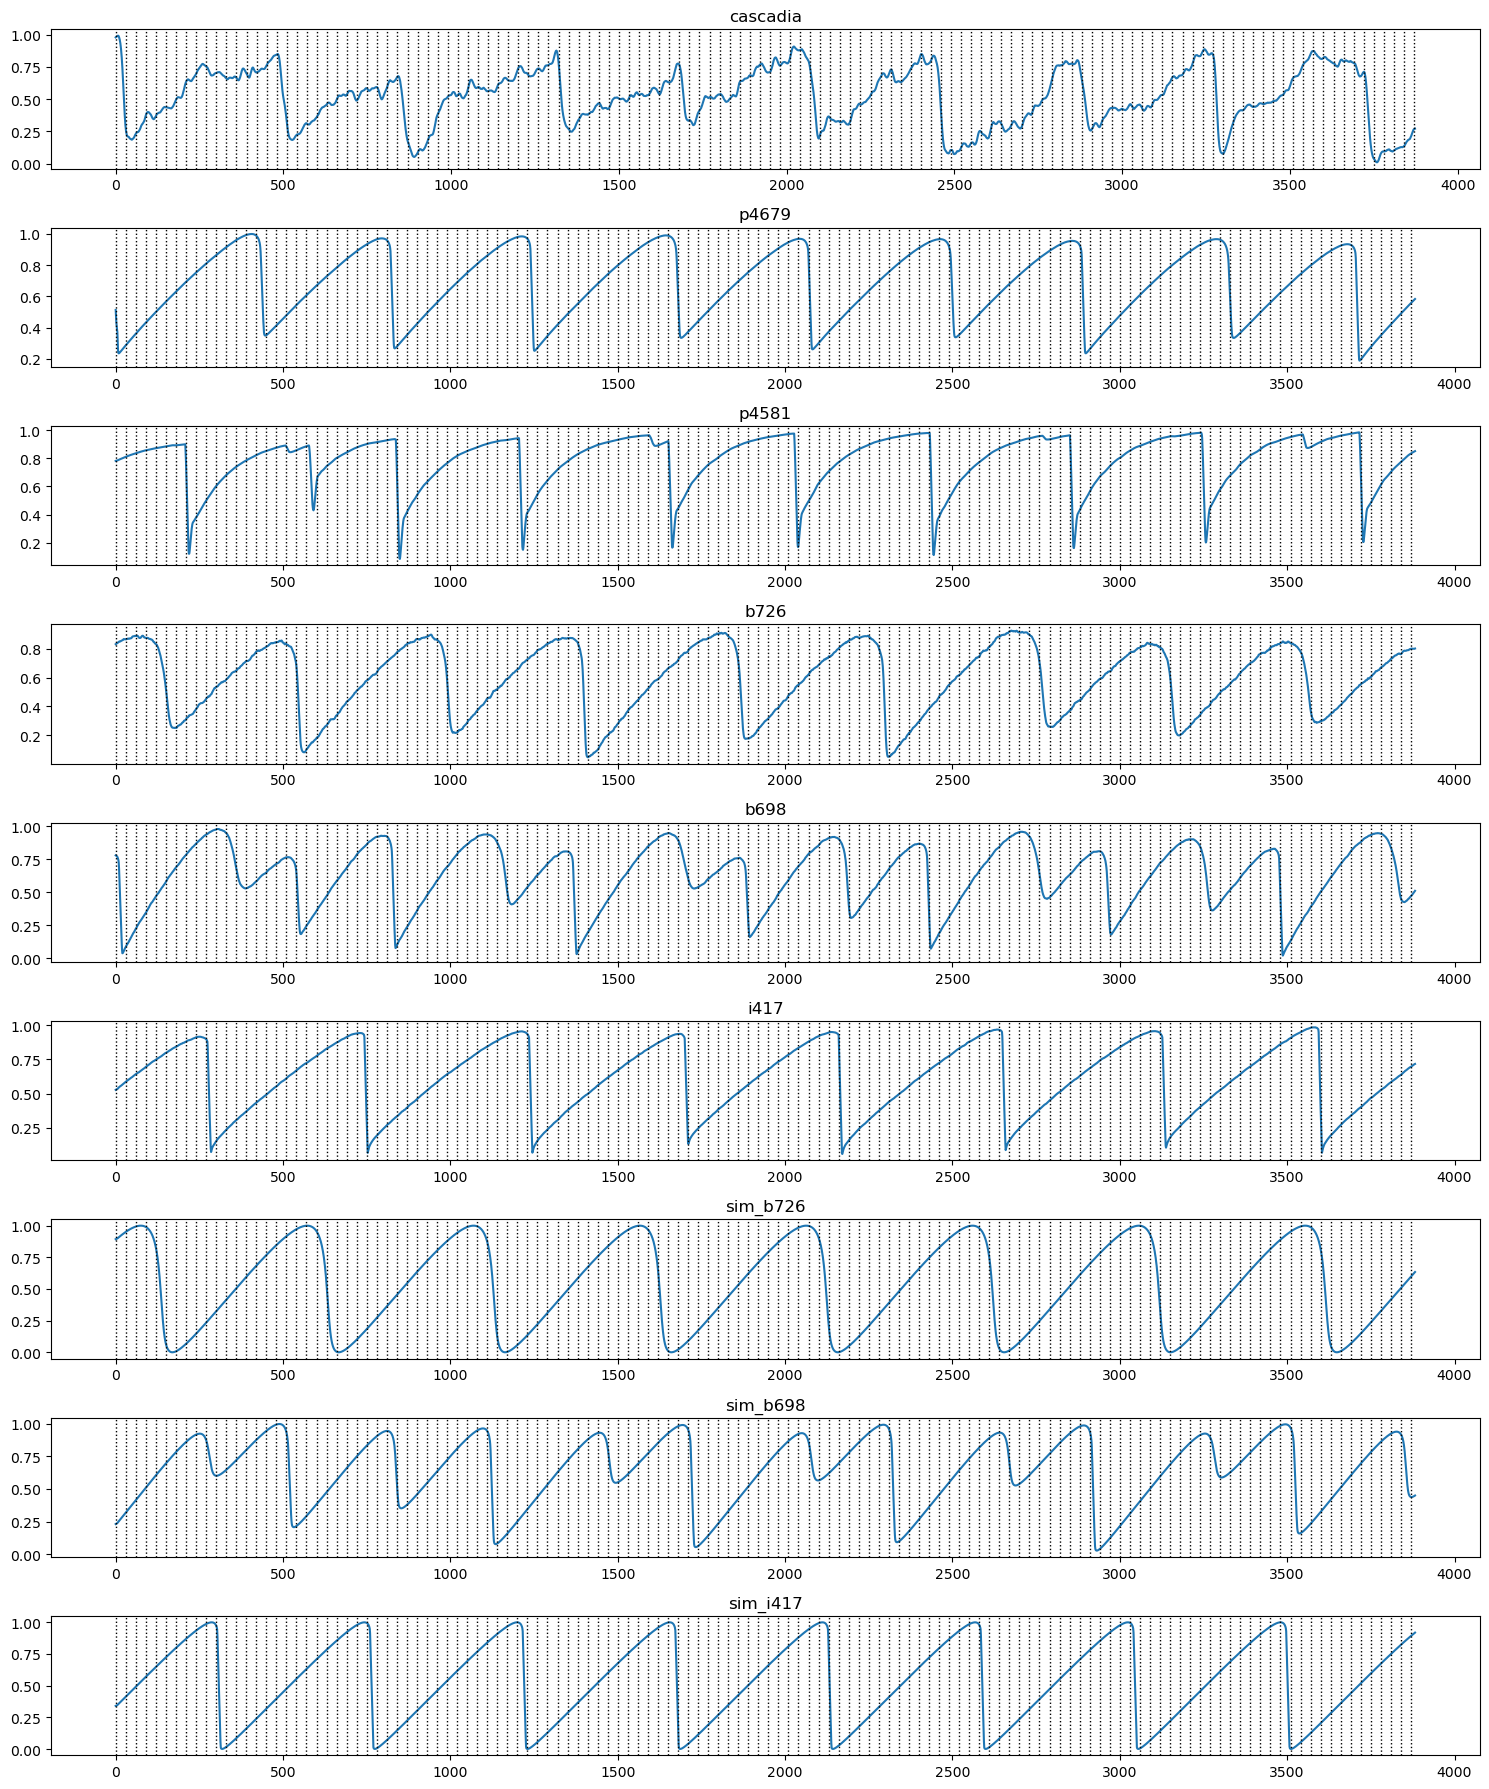

In [36]:
# Plot extra smoothed data
## Truncate length of all dataframes to match the length of 'cascadia' dataframe
cascadia_length = len(df["cascadia"])

df_truncated = {exp: df_exp.head(cascadia_length) for exp, df_exp in df_extra_smooth.items()}

## Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp].reset_index()  # Reset index to ensure 'id' column exists
    sns.lineplot(data=data, x=data.index, y=data.columns[1])  # Use the DataFrame index for x
    for x in np.arange(0, len(data), 30):
        plt.axvline(x=x, color='black', linestyle=':', linewidth=1)
    plt.title(exp)
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()
plt.show()

In [42]:
# Calculate first derivative
first_derivative = {
    exp: np.gradient(df_extra_smooth[exp][0])
    for exp in EXPERIMENTS
}

In [43]:
# Calculate second derivative
second_derivative = {
    exp: np.gradient(first_derivative[exp])
    for exp in EXPERIMENTS
}

/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

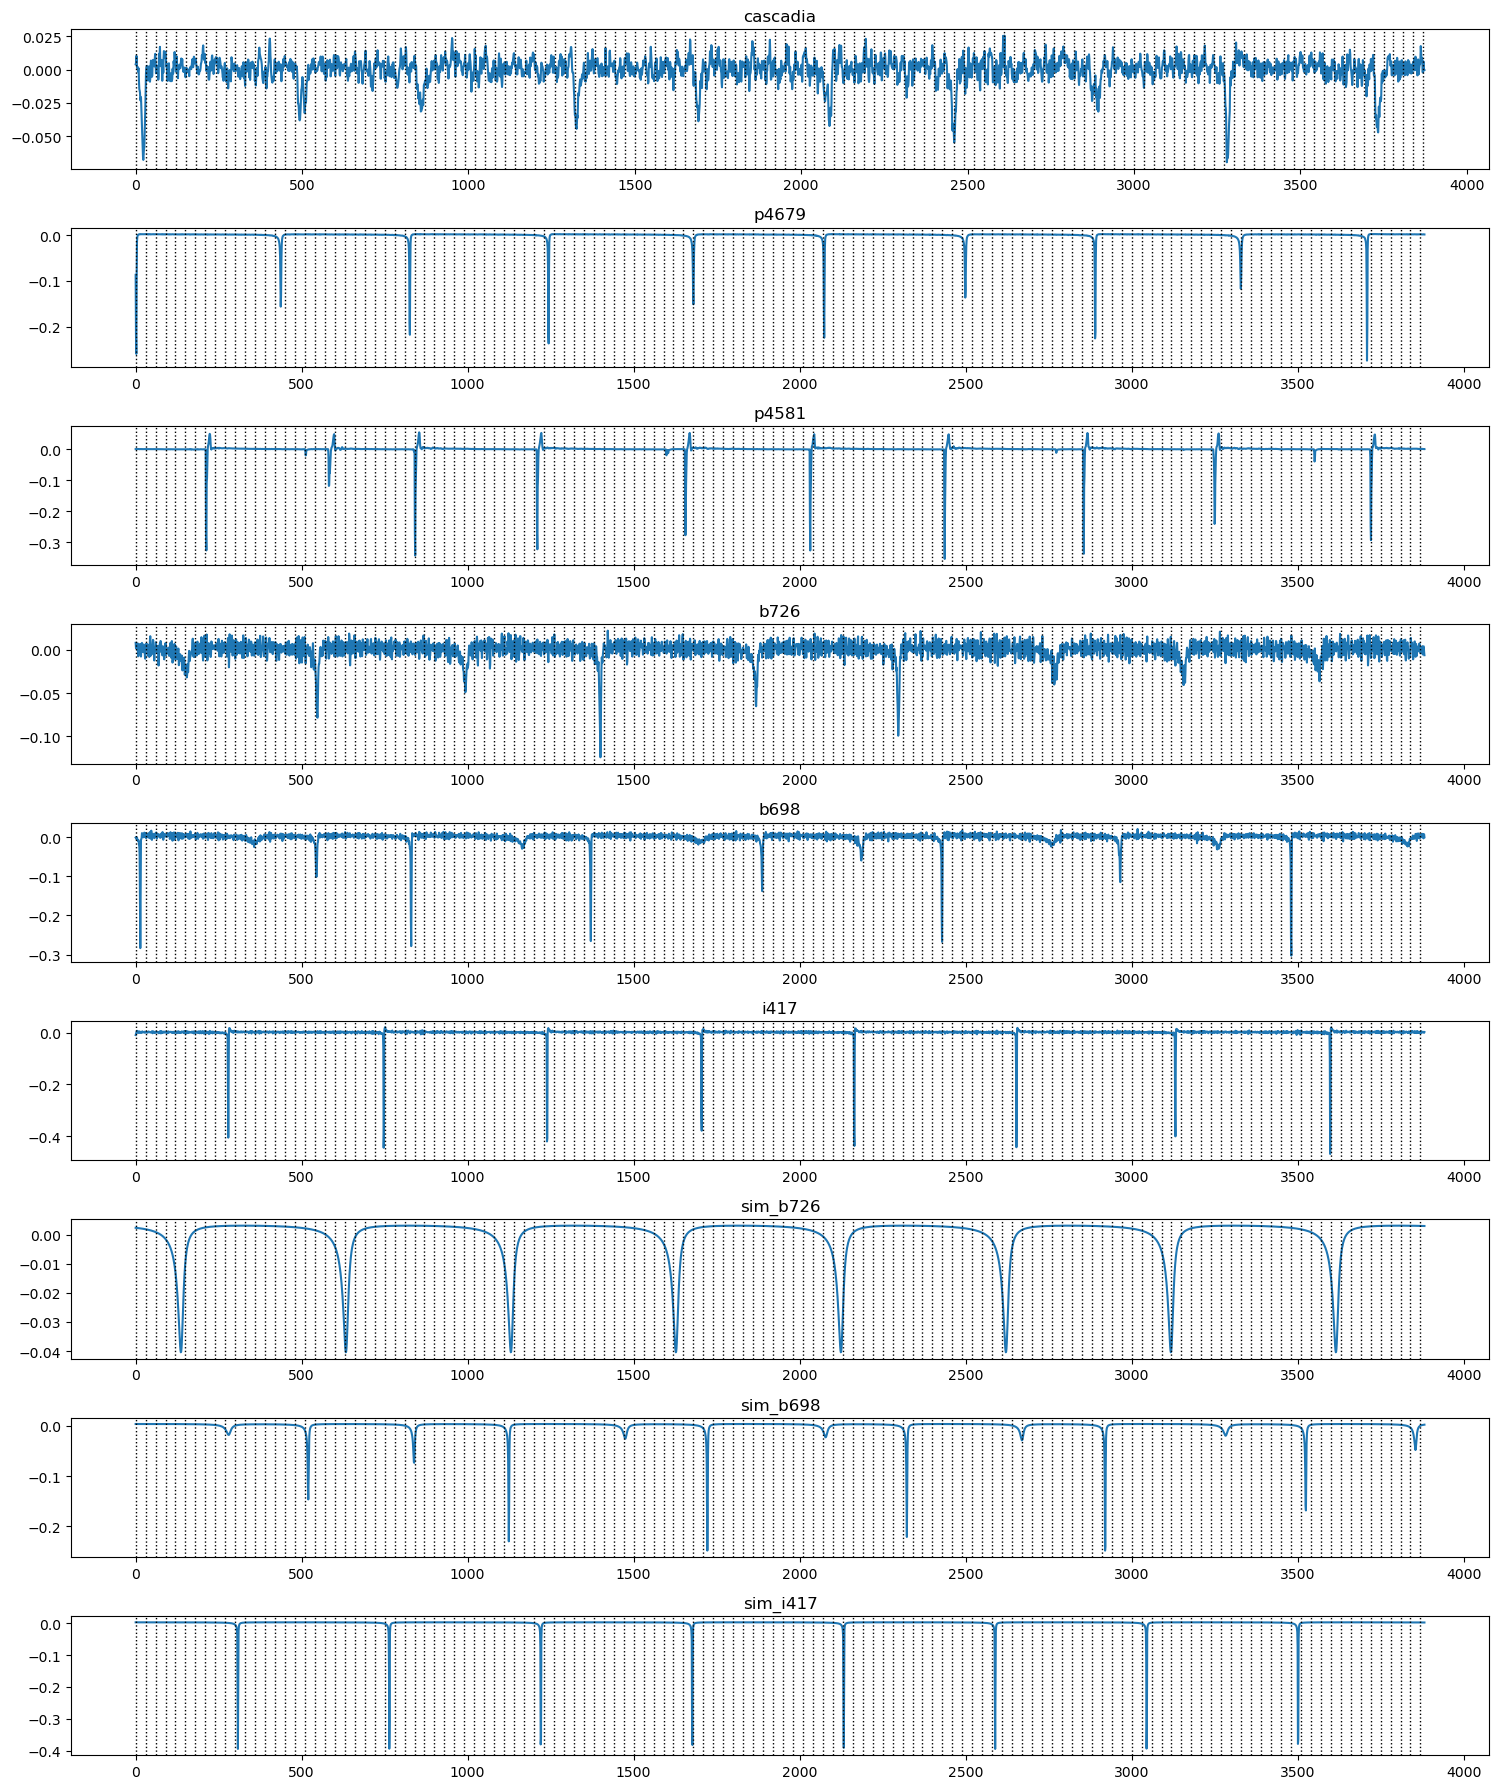

In [44]:
# Plot first derivative
## Truncate length of all dataframes to match the length of 'cascadia' dataframe
cascadia_length = len(df["cascadia"])

df_truncated = {exp: df_exp[:cascadia_length] for exp, df_exp in first_derivative.items()}

## Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp]  # NumPy array
    y_values = data  # Assuming you want to plot the first column
    x_values = np.arange(len(y_values))  # Assuming x-axis is just index
    sns.lineplot(x=x_values, y=y_values)  # Plotting NumPy array directly
    for x in np.arange(0, len(y_values), 30):
        plt.axvline(x=x, color='black', linestyle=':', linewidth=1)
    plt.title(exp)
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()
plt.show()

/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/jpoff/miniconda3/envs/gtc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

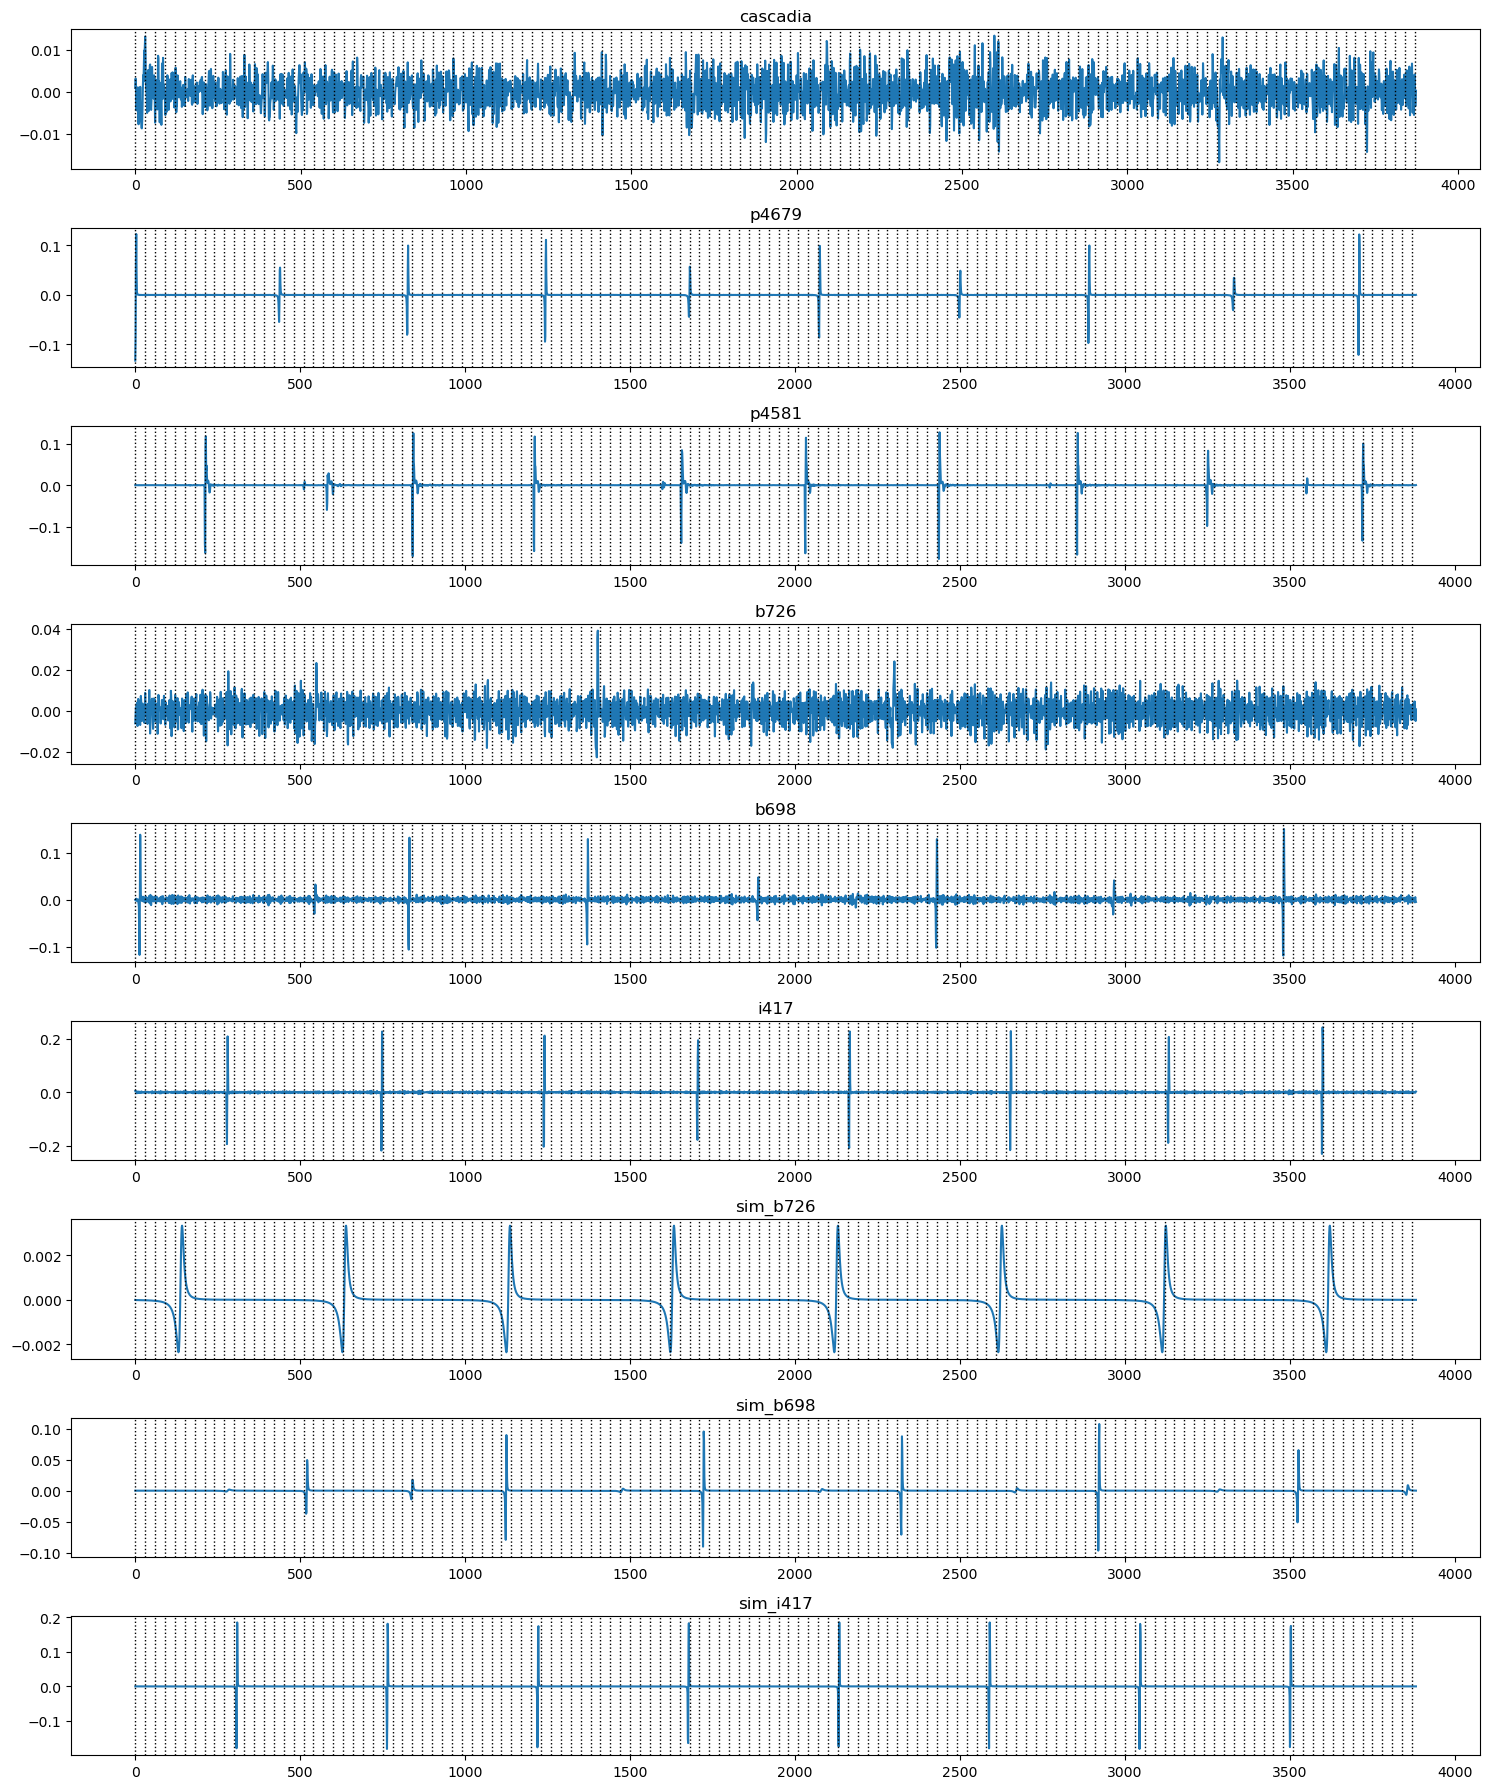

In [45]:
# Plot second derivative
## Truncate length of all dataframes to match the length of 'cascadia' dataframe
cascadia_length = len(df["cascadia"])

df_truncated = {exp: df_exp[:cascadia_length] for exp, df_exp in second_derivative.items()}

## Sort experiments to start with 'cascadia', then plot all data
sorted_experiments = ['cascadia'] + [exp for exp in EXPERIMENTS if exp != 'cascadia']

plt.figure(figsize=(15, len(sorted_experiments) * 2))
for i, exp in enumerate(sorted_experiments, 1):
    plt.subplot(len(sorted_experiments), 1, i)
    data = df_truncated[exp]  # NumPy array
    y_values = data  # Assuming you want to plot the first column
    x_values = np.arange(len(y_values))  # Assuming x-axis is just index
    sns.lineplot(x=x_values, y=y_values)  # Plotting NumPy array directly
    for x in np.arange(0, len(y_values), 30):
        plt.axvline(x=x, color='black', linestyle=':', linewidth=1)
    plt.title(exp)
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()
plt.show()

In [21]:
# Calculate weights based on second derivative (decisions on: scaled? exponential? ReLU?)


In [ ]:
# Visualise weights


## Windowed datasets

In [ ]:
# Create datasets (use create_dataset)

In [ ]:
# Data scaling (use normalise_dataset)

## Custom loss function

TODO: Finish the function

Additional inputs to add to function: 
- extra smoothing window (or just dataset name and have these defined in the function)
- derivative scaling parameters (again could have these defined in the function based on datatset name)
- also include lookback to be able to use these values to avoid edge effects when calculting derivatives


Other the whole dataset, weightings should sum to 0.  
Should square root be applied at the end??


In [35]:
# Custom loss function based around Andrew's suggestions
def custom_loss1(y_true, y_pred):
    """
    Description
    """
    import torch
    import numpy as np
    import pandas as pd

    square_error = (y_true - y_pred)**2

    EXTRA_SMOOTHING_WINDOW = 1
    MIN_PERIODS = 1

    y_true_smooth = y_true.rolling(EXTRA_SMOOTHING_WINDOW, MIN_PERIODS, center=True).mean()

    first_derivative = np.gradient(y_true_smooth)
    second_derivative = np.gradient(first_derivative)

    weightings = ... # should depend on magnitude of exp or ReLU of second derivative

    alpha = ... # should be a scaling factor based on second derivative distribution for the whole dataset
    weighted_loss = torch.mean(square_error * (1 + alpha * weightings))

    return weighted_loss


## Testing implementation

Final TODO: Write this function as a script and with others work out how it is opererationalised in the existing training pipelines.